<a href="https://www.kaggle.com/code/arturshopengauer/topic-11-rnn-gru-lstm-keggle?scriptVersionId=288021175" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/conll003-englishversion/valid.txt
/kaggle/input/conll003-englishversion/metadata
/kaggle/input/conll003-englishversion/test.txt
/kaggle/input/conll003-englishversion/train.txt


# **Завантаження необхідних бібліотек**

In [2]:
import os
import gc
import math
import random
from collections import defaultdict

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from torch.optim import Adam
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import classification_report, f1_score

import warnings
warnings.filterwarnings('ignore')

Визначимо шлях до даних і пристрій, на якому будемо проводити розрахунки.

In [3]:
data_path = '/kaggle/input/conll003-englishversion/'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


будемо зчитувати тільки елементи на позиції 0 — слова — і 3 — мітки іменованих сутностей. У коді це буде відображатися так: sentences.append((l[0], l[3].strip('\\n'))).

In [4]:
def load_sentences(filepath):
    final = []
    sentences = []
    with open(filepath, 'r') as f:
        for line in f.readlines():
            if (line == ('-DOCSTART- -X- -X- O\\n') or line == '\n'):
                if len(sentences) > 0:
                    final.append(sentences)
                    sentences = []
            else:
                l = line.split(' ')
                sentences.append((l[0], l[3].strip('\n')))
    return final
    
train_sents = load_sentences(data_path + 'train.txt')
test_sents = load_sentences(data_path + 'test.txt')
val_sents = load_sentences(data_path + 'valid.txt')

train_sents[:3]

[[('-DOCSTART-', 'O')],
 [('EU', 'B-ORG'),
  ('rejects', 'O'),
  ('German', 'B-MISC'),
  ('call', 'O'),
  ('to', 'O'),
  ('boycott', 'O'),
  ('British', 'B-MISC'),
  ('lamb', 'O'),
  ('.', 'O')],
 [('Peter', 'B-PER'), ('Blackburn', 'I-PER')]]

Визначимо список міток класів і закодуємо їх для чисельного представлення.



In [5]:
ner_labels = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
id2label = {str(i): label for i, label in enumerate(ner_labels)}
label2id = {value: int(key) for key, value in id2label.items()}


Представимо наші завантажені речення як словник, де під ключем text будуть зберігатися наші речення, а під ключем label — відповідні мітки іменованих сутностей.

In [6]:
def get_df(samples):
    df,label = [], []
    for lines in samples:
        cur_line, cur_label = list(zip(*lines))
        df.append(list(cur_line))
        label.append([label2id[i] for i in cur_label])
    return {'text':df, 'label':label}
    
    
train_df = get_df(train_sents)
test_df = get_df(test_sents)
val_df = get_df(val_sents)

Для подальшої роботи з даними нам потрібно представити їх у чисельній формі.

Спочатку побудуємо словник. Для цього спершу підрахуємо кількість появи кожного слова в корпусі.

In [7]:
word_dict = defaultdict(int)

for line in train_df['text']:
    for word in line:
        word_dict[word] += 1

Ми не будемо використовувати слова, які дуже рідко з’являються, для тренування. Таким чином, ми зменшимо кількість неінформативних ознак у наборі даних.

In [8]:
lower_freq_word = []
for k,v in word_dict.items():
    if v < 2:
        lower_freq_word.append(k)

for word in lower_freq_word:
    del word_dict[word]

Додамо до словника два спеціальні токени.
Перший токен <UNK> позначатиме всі слова, які не присутні у словнику, так звані Out Of Vocabulary words, OOV words.
Другий токен <PAD> позначає падинг (padding).

In [9]:
word_dict['<UNK>'] = -1
word_dict['<PAD>'] = -2


створюємо словник, який буде містити слово та його індекс. Ми будемо використовувати цей словник, щоб представити наші речення в числовому вигляді для подальшої обробки нейронною мережею.

In [10]:
word2id = {}

for idx, word in enumerate(word_dict.keys()):
  word2id[word] = idx

**Dataset і DataLoader****

In [11]:
def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w in to_ix.keys():
            idxs.append(to_ix[w])
        else:
            idxs.append(to_ix['<UNK>'])
    return idxs

Опишемо клас Dataset, необхідний для абстракції та організації даних під час навчання моделі. Він дозволяє легко керувати даними, завантажувати їх і забезпечує доступ до окремих прикладів даних і їхніх міток.

In [12]:
class CoNLLDataset(Dataset):
    def __init__(self, df):
        self.texts = df['text']
        self.labels = df['label']

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_sequence(self.texts[item], word2id)
        label = self.labels[item]
        return {
            'input_ids': inputs,
            'labels': label
        }

Для тренування поточної моделі нам необхідно визначити collate-функцію

In [16]:
class Collate:
    def __init__(self, train):
        self.train = train

    def __call__(self, batch):
        output = dict()
        output["input_ids"] = [sample["input_ids"] for sample in batch]
        if self.train:
            output["labels"] = [sample["labels"] for sample in batch]

        # calculate max token length of this batch
        batch_max = max([len(ids) for ids in output["input_ids"]])

        # add padding

        output["input_ids"] = [s + (batch_max - len(s)) * [word2id['<PAD>']] for s in output["input_ids"]]
        if self.train:
            output['labels'] = [s + (batch_max - len(s)) * [-100] for s in output["labels"]]

        # convert to tensors
        output["input_ids"] = torch.tensor(output["input_ids"], dtype=torch.long)
        if self.train:
            output["labels"] = torch.tensor(output["labels"], dtype=torch.long)

        return output
    
collate_fn = Collate(True)

**Клас моделі**

In [19]:
# 1. embeddings  шар ембедингів.

2. lstm — шар, який відповідає за Bi-LSTM-компонент у нашій мережі.



 - embedding_dim визначає розмірність вхідних векторів.
 - hidden_dim визначає розмірність прихованих станів і вихідного тензора.
 - bidirectional робить LSTM двонаправленою.
 - num_layers дозволяє створити глибоку модель з трьома послідовними LSTM-шарами.
 - batch_first вказує, що перший розмір вхідного тензора відповідає розміру батчу, що полегшує обробку даних у батчах.
 - fc створює повнозв'язний (лінійний) шар.
 - output_size визначає кількість нейронів у вихідному шарі, що відповідає кількості класів у задачі класифікації.

In [21]:
class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()
        
        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=3, batch_first=True)

        # 3. Dense Layer
        self.fc = nn.Linear(2*hidden_dim, output_size)
        
    def forward(self, batch_text):

        embeddings = self.embeddings(batch_text)
        
        lstm_output, _ = self.lstm(embeddings) 

        logits = self.fc(lstm_output)
        return logits

Допоміжні функції для тренування

Оскільки нас цікавить тільки якість передбачення для міток іменованих сутностей, будемо прибирати з результатів токени зі значенням, меншим за 0.

In [22]:
def remove_predictions_for_masked_items(predicted_labels, correct_labels): 

    predicted_labels_without_mask = []
    correct_labels_without_mask = []
        
    for p, c in zip(predicted_labels, correct_labels):
        if c > 0:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)
            
    return predicted_labels_without_mask, correct_labels_without_mask

Тепер визначимо функцію, відповідальну за навчання й валідацію. Як валідаційну метрику використаємо macro F1.

In [23]:
def train(model, train_loader, val_loader, batch_size, max_epochs, num_batches, patience, output_path):
    criterion = nn.CrossEntropyLoss(ignore_index=-100)  # we mask the <pad> labels
    optimizer = Adam(model.parameters())

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    for epoch in range(max_epochs):

        total_loss = 0
        predictions, correct = [], []
        model.train()
        for batch in tqdm(train_loader, total=num_batches, desc=f"Epoch {epoch}"):
            
            cur_batch_size, text_length = batch['input_ids'].shape
            
            pred = model(batch['input_ids'].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch['labels'].to(device).view(cur_batch_size*text_length)
            
            loss = criterion(pred, gold)
            
            total_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)
            
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch['labels'].view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        train_score = f1_score(correct, predictions, average="macro")
        train_f_score_history.append(train_score)
            
        print("Total training loss:", total_loss)
        print("Training Macro F1:", train_score)
        
        total_loss = 0
        predictions, correct = [], []
        
        model.eval()
        with torch.no_grad():
            for batch in val_loader:

                cur_batch_size, text_length = batch['input_ids'].shape
                
                pred = model(batch['input_ids'].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
                gold = batch['labels'].to(device).view(cur_batch_size*text_length)
                
                loss = criterion(pred, gold)
                total_loss += loss.item()

                _, pred_indices = torch.max(pred, 1)
                predicted_labels = list(pred_indices.cpu().numpy())
                correct_labels = list(batch['labels'].view(cur_batch_size*text_length).numpy())

                predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                       correct_labels)

                predictions += predicted_labels
                correct += correct_labels

        dev_score = f1_score(correct, predictions, average="macro")
            
        print("Total validation loss:", total_loss)
        print("Validation Macro F1:", dev_score)
        
        dev_f = dev_score
        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model.")
            torch.save(model, output_path)
            no_improvement = 0
            
        if no_improvement > patience:
            print("Validation F-score does not improve anymore. Stop training.")
            dev_f_score_history.append(dev_f)
            break
            
        dev_f_score_history.append(dev_f)
        
    return train_f_score_history, dev_f_score_history

☝ Зверніть увагу, тут ми додаємо механізм ранньої зупинки тренування.

Визначимо функцію для тестування.

In [24]:
def test(model, test_iter, batch_size, labels, target_names): 
    total_loss = 0
    predictions, correct = [], []
    
    model.eval()
    with torch.no_grad():    
    
        for batch in test_iter:

            cur_batch_size, text_length = batch['input_ids'].shape

            pred = model(batch['input_ids'].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch['labels'].to(device).view(cur_batch_size*text_length)

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch['labels'].view(cur_batch_size*text_length).numpy())

            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)

            predictions += predicted_labels
            correct += correct_labels
    
    print(classification_report(correct, predictions, labels=labels, target_names=target_names))

# ***Тренування моделі***

Спершу визначимо гіперпараметри моделі.

In [25]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
NUM_CLASSES = len(id2label)
MAX_EPOCHS = 50
PATIENCE = 3
BATCH_SIZE = 32
VOCAB_SIZE = len(word2id)
OUTPUT_PATH = "/tmp/bilstmtagger"
num_batches = math.ceil(len(train_df) / BATCH_SIZE)


**Створимо об’єкти Dataset і DataLoader.**

In [27]:
train_dataset = CoNLLDataset(train_df)
val_dataset = CoNLLDataset(val_df)
test_dataset = CoNLLDataset(test_df)

train_loader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=4,
                              pin_memory=True,
                              drop_last=False)

val_loader = DataLoader(val_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=4,
                              pin_memory=True,
                              drop_last=False)

test_loader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=4,
                              pin_memory=True,
                              drop_last=False)


Створимо об’єкт моделі.

In [28]:
tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES) 
tagger


BiLSTMTagger(
  (embeddings): Embedding(11987, 100)
  (lstm): LSTM(100, 64, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=9, bias=True)
)

# **Нарешті, переходимо до тренування!**

In [29]:
train_f, dev_f = train(tagger.to(device), train_loader, val_loader, BATCH_SIZE, MAX_EPOCHS, 
                       num_batches, PATIENCE, OUTPUT_PATH)


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 353.7434974461794
Training Macro F1: 0.03958767667117996
Total validation loss: 56.29690897464752
Validation Macro F1: 0.1554037990179885
Saving model.


Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 171.02498000487685
Training Macro F1: 0.3665205388207673
Total validation loss: 31.01619492098689
Validation Macro F1: 0.4346473736511767
Saving model.


Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 93.21458024391904
Training Macro F1: 0.6064505186631693
Total validation loss: 24.45226603979245
Validation Macro F1: 0.6234792997648577
Saving model.


Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 55.376461032545194
Training Macro F1: 0.7211550380348635
Total validation loss: 20.128109176643193
Validation Macro F1: 0.6809185337479585
Saving model.


Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 34.77021627500653
Training Macro F1: 0.7875147985212563
Total validation loss: 18.936612374614924
Validation Macro F1: 0.6957778376683812
Saving model.


Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 22.967172321339604
Training Macro F1: 0.8264177756684377
Total validation loss: 19.31780520780012
Validation Macro F1: 0.7048070549651843
Saving model.


Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 16.73148449230939
Training Macro F1: 0.845338835270022
Total validation loss: 19.7083716384368
Validation Macro F1: 0.709878629100563
Saving model.


Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 12.158050220925361
Training Macro F1: 0.8582833626513469
Total validation loss: 22.063346865965286
Validation Macro F1: 0.7106468894772776
Saving model.


Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 9.011046217085095
Training Macro F1: 0.8661551110993163
Total validation loss: 22.61647942804848
Validation Macro F1: 0.7056829655660253


Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 7.48868500032404
Training Macro F1: 0.8706112565766119
Total validation loss: 23.365522129897727
Validation Macro F1: 0.706516754359169


Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 7.52255159667402
Training Macro F1: 0.8723766260019924
Total validation loss: 23.487518389600154
Validation Macro F1: 0.7187328394024858
Saving model.


Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 5.2056557618197985
Training Macro F1: 0.8770809252436663
Total validation loss: 22.84549219026667
Validation Macro F1: 0.7259519835597672
Saving model.


Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 3.730433019645716
Training Macro F1: 0.8817391806991443
Total validation loss: 24.093764073120838
Validation Macro F1: 0.7297105027250947
Saving model.


Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 2.674404811583372
Training Macro F1: 0.8827293187581541
Total validation loss: 25.0675460514758
Validation Macro F1: 0.7257806087564396


Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 2.5441998308870097
Training Macro F1: 0.883515122476322
Total validation loss: 26.018436818634655
Validation Macro F1: 0.7213237091726225


Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 4.597531857076319
Training Macro F1: 0.8770885805688063
Total validation loss: 23.922181680827634
Validation Macro F1: 0.722225625693545


Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 3.5224977466768905
Training Macro F1: 0.8804028458690291
Total validation loss: 25.844663131625566
Validation Macro F1: 0.728417654211265
Validation F-score does not improve anymore. Stop training.


*Візуалізуємо навчальну й валідаційну метрики.*

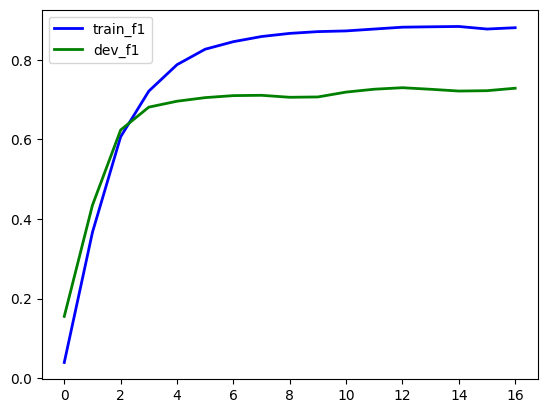

In [30]:
df = pd.DataFrame({'epochs': range(0,len(train_f)), 
                  'train_f1': train_f, 
                   'dev_f1': dev_f})

plt.plot('epochs', 'train_f1', data=df, color='blue', linewidth=2)
plt.plot('epochs', 'dev_f1', data=df, color='green', linewidth=2)
plt.legend()
plt.show()


Перевіримо якість моделі на тестовому наборі даних. Завантажимо кращу зі збережених моделей.

In [33]:
tagger = torch.load(OUTPUT_PATH, weights_only=False)


Виконаємо перевірку.

In [34]:
labels = list(label2id.keys())[1:]
label_idxs = list(label2id.values())[1:]

test(tagger, test_loader, BATCH_SIZE, labels = label_idxs, target_names = labels)


              precision    recall  f1-score   support

       B-PER       0.89      0.66      0.76      1617
       I-PER       0.90      0.75      0.82      1156
       B-ORG       0.81      0.62      0.70      1661
       I-ORG       0.85      0.70      0.76       835
       B-LOC       0.88      0.79      0.83      1668
       I-LOC       0.75      0.60      0.67       257
      B-MISC       0.76      0.66      0.70       702
      I-MISC       0.64      0.60      0.62       216

   micro avg       0.85      0.69      0.76      8112
   macro avg       0.81      0.67      0.73      8112
weighted avg       0.85      0.69      0.76      8112

